# About this Notebook:

Here we aim to build a baseline model:
- Model Processing: CountVectorize
- Model explored: Multinomial Naive Bayes

## Recall Problem statement and model objective:

*Problem statement:*<br>
We aim to create a classification model that will improve investment chance of successful investment in pre-released or early-accessed games by looking into the <code>game's description</code>.

- We look at a <code>'Good' game</code> ('Successful' game) as a game defined to be well received by users, in other words, games which received largely positive reviews. 
- So our main feature focus on the <code>game description</code>, and our target variable is whether a game has high percentage of positive reviews (<code>'Good' game</code>).

The model performance will be compared and assessed against the investment chance of investing in a successful game without using the model (default probability = percentage of defined 'Successful' games in the dataset). As such, our main assessment metrics of the model is it's <code>precision</code>.

In Summary:
|X features|y target variable|Model Assessment|
|---|---|---|
|game description|Good Game or Poor Games|Precision core|

# Imports & Functions

### Libraries

In [25]:
import numpy as np 
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#Visualisation:
import seaborn               as sns
import matplotlib.pyplot     as plt


from tqdm import tqdm
tqdm.pandas()

In [26]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


# sklearn: Import metrics.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score #sensitivity
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report #precision+recall+f1-score

### Functions

In [25]:
#Showing missing, duplicates, shape, dtypes
def df_summary(df):
    print(f"Shape(col,rows): {df.shape}")
    print(f"Number of duplicates: {df.duplicated().sum()}")
    print('---'*20)
    print(f'Number of each unqiue datatypes:\n{df.dtypes.value_counts()}')
    print('---'*20)
    print("Columns with missing values:")
    isnull_df = pd.DataFrame(df.isnull().sum()).reset_index()
    isnull_df.columns = ['col','num_nulls']
    isnull_df['perc_null'] = ((isnull_df['num_nulls'])/(len(df))).round(2)
    print(isnull_df[isnull_df['num_nulls']>0])

In [37]:
#function for model fitting and printing out model performance
def fit_score_(model):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f"Train accuracy score:{model.score(X_train, y_train)}")
    print(f"Test accuracy score:{model.score(X_test, y_test)}")
    print(f"Train f1 score:{f1_score(y_train, y_train_pred)}")
    print(f"Test f1 score:{f1_score(y_test, y_test_pred)}")
    print("\n")
    print(classification_report(y_test, y_test_pred))
    print("\n")
    
    cm = confusion_matrix(y_test, y_test_pred) 
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Poor Games','Good games']).plot(cmap='Blues')
    plt.show();

### Data imports and quick view

In [27]:
df = pd.read_csv("cleaned_dataset.csv")
df_summary(df)

Shape(col,rows): (27309, 12)
Number of duplicates: 0
------------------------------------------------------------
Number of each unqiue datatypes:
object     6
int64      4
float64    1
bool       1
dtype: int64
------------------------------------------------------------
Columns with missing values:
Empty DataFrame
Columns: [col, num_nulls, perc_null]
Index: []


In [28]:
df.columns

Index(['title', 'r_date', 'price', 'description', 'review_type',
       'review_stats', 'positive_percentage', 'total_reviews', 'tagged',
       'game_id', 'Good_Game', 'r_year'],
      dtype='object')

In [29]:
df.head()

,title,r_date,price,description,review_type,review_stats,positive_percentage,total_reviews,tagged,game_id,Good_Game,r_year
0,persona 3 portable,2023-01-18,27.99,experience the iconic critically acclaimed rpg...,mostly positive,74% of the 771 user reviews for this game are...,74,771,"rpg, story rich, anime, turn-based combat, jrp...",1809700,True,2023
1,fraymakers,2023-01-18,22.79,what is fraymakersfraymakers is the ultimate c...,mixed,68% of the 214 user reviews for this game are...,68,214,"indie, fighting, 2d fighter, multiplayer, acti...",1420350,False,2023
2,osiris: new dawn,2023-01-18,39.99,inspired by the edgier side of sci fi osiris n...,mostly negative,31% of the 127 user reviews in the last 30 da...,31,127,"open world survival craft, horror, survival, s...",402710,False,2023
3,lake haven - chrysalis,2023-01-18,3.89,on october 7th at 9 pm the kansas police depar...,positive,100% of the 27 user reviews for this game are...,100,27,"third person, exploration, singleplayer, adven...",1696960,True,2023
4,predictors,2023-01-18,3.89,turnbased roguelikego solo or invite up to thr...,positive,95% of the 20 user reviews for this game are ...,95,20,"roguelike, roguelite, turn-based, online co-op...",2149330,True,2023


# Part 1: Model Preprocessing:


## CountVectorize

In [30]:
cvec = CountVectorizer(stop_words = 'english',max_features=1500)
X_cvec = cvec.fit_transform(df.loc[:,'description'])

X_df = pd.DataFrame(X_cvec.toarray(),columns = cvec.get_feature_names_out())
X_df.shape

(27309, 1500)

### Quick look on the 1500 terms obtained after CountVect

#### Most common words

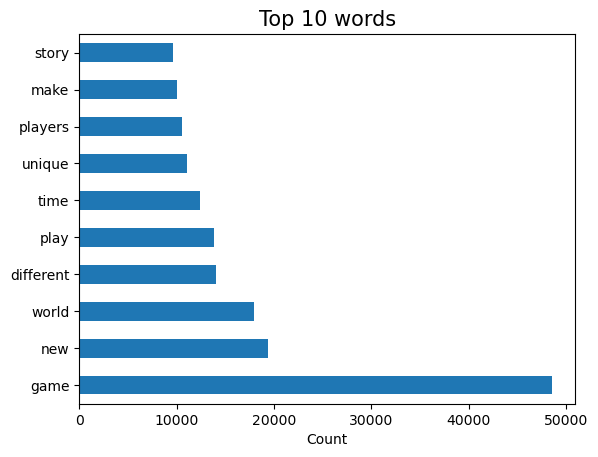

In [31]:
X_df.sum().sort_values(ascending=False).head(10).plot(kind="barh")
plt.title("Top 10 words",fontsize=15)
plt.xlabel("Count");

In [32]:
#the word 'game' appeared more than the number of games in our dataset
X_df['game'].sum()

48494

In [33]:
#how many percent of the game description contain the word game?
len(df[df['description'].str.contains('game')])/len(df)

0.8203156468563477

In [34]:
#how many percent of the game description contain the word new?
len(df[df['description'].str.contains('new')])/len(df)

0.4038229155223553

**Comment**:

The most frequent word 'game' appeared more than 80% of the game's description, while the next most common word 'new' appeared in 40% of them.

#### Least common words

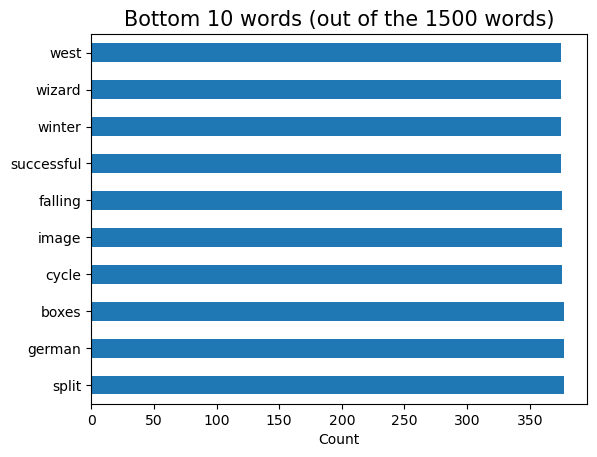

In [35]:
X_df.sum().sort_values(ascending=False).tail(10).plot(kind="barh")
plt.title("Bottom 10 words (out of the 1500 words)",fontsize=15)
plt.xlabel("Count");

# Part 2: Modelling (Naive Bayes)

y_train:


True     0.721205
False    0.278795
Name: Good_Game, dtype: float64



y_test:


True     0.721148
False    0.278852
Name: Good_Game, dtype: float64



Train accuracy score:0.6920072262096577
Test accuracy score:0.6764792032806093
Train f1 score:0.7824077268023457
Test f1 score:0.7716795865633075


              precision    recall  f1-score   support

       False       0.43      0.47      0.45      1904
        True       0.79      0.76      0.77      4924

    accuracy                           0.68      6828
   macro avg       0.61      0.61      0.61      6828
weighted avg       0.69      0.68      0.68      6828





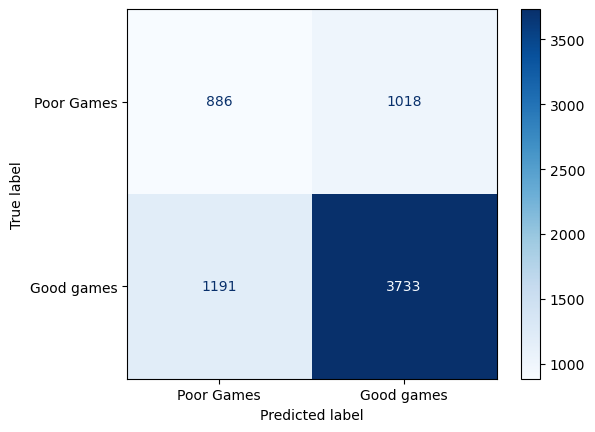

In [38]:
_df = df.copy()

X = _df['description']
y = _df['Good_Game']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y) 

print(f"y_train:")
y_train.value_counts(normalize=True)
print("\n")
print(f"y_test:")
y_test.value_counts(normalize=True)
print("\n")

cvec = CountVectorizer(stop_words = 'english',max_features=1500)

X_train = cvec.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(),
                       columns = cvec.get_feature_names_out())

X_test = cvec.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(),
                      columns = cvec.get_feature_names_out())

nb = MultinomialNB()
fit_score_(nb)

**Comments**:

In the interest of answering our business problem, our focus is mainly on precision (% of True 'Good Games' among those who are predicted to be 'Good Games'.)
- While the model has good recall(0.99), it has poor precision (precision = 79% VS 72% actual 'Good Games' in the test set).
- This will does somewhat well for our stakeholder, as the chances of them obtaining a 'Good Game' did increased by 7% with the use of the model.

|Model|Description|Performance|
|---|---|---|
|Baseline Model<br>Multinomial Naive Bayes|Processes:<br> CountVectorizer<br>(stop_words = 'english',<br>max_features=1500)|<li>Score to beat: 72% <li> Model Precision score: 79%|


**How are we going to improve model's performance?**
1. Explore using different choice of model (e.g. Random Forest)
1. Include Stemming/Lemitisation during preprocessing
1. Apply conditions such as *min_df* and *max_df* during vectorisation
1. Attempt using TFIDF vs CountVectorizer
1. Attempt searching for Bigrams

We will explore these approaches in subsequent notebook.